In [2]:
import gc
import random

import numpy as np
import pandas as pd
import polars as pl

# from astronet.constants import LSST_FILTER_MAP as ELASTICC_FILTER_MAP
from astronet.constants import ELASTICC_FILTER_MAP
from astronet.constants import LSST_PB_COLORS as ELASTICC_PB_COLORS
from astronet.preprocess import (
    generate_gp_all_objects,
    generate_gp_single_event,
    remap_filters,
)
# from astronet.viz.visualise_data import plot_event_data_with_model, plot_event
from elasticc.constants import CLASS_MAPPING, ROOT

SEED = 9001

pd.options.mode.dtype_backend = "pyarrow"

import matplotlib as mpl
import matplotlib.pyplot as plt


plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "sans-serif",
            "font.serif": ["Computer Modern Roman"],
        }
)


In [3]:
def extract_history(history_list: list, field: str) -> list:
    """Extract the historical measurements contained in the alerts
    for the parameter `field`.

    Parameters
    ----------
    history_list: list of dict
        List of dictionary from alert[history].
    field: str
        The field name for which you want to extract the data. It must be
        a key of elements of history_list

    Returns
    ----------
    measurement: list
        List of all the `field` measurements contained in the alerts.
    """
    if history_list is None:
        return []
    try:
        measurement = [obs[field] for obs in history_list]
    except KeyError:
        print("{} not in history data".format(field))
        measurement = []

    return measurement


def extract_field(alert: dict, category: str, field: str, key: str) -> np.array:
    """Concatenate current and historical observation data for a given field.

    Parameters
    ----------
    alert: dict
        Dictionnary containing alert data
    category: str
        prvDiaSources or prvDiaForcedSources
    field: str
        Name of the field to extract.

    Returns
    ----------
    data: np.array
        List containing previous measurements and current measurement at the
        end. If `field` is not in the category, data will be
        [alert['diaSource'][field]].
    """
    data = np.concatenate([[alert[key][field]], extract_history(alert[category], field)])
    return data



In [359]:
labels = [
#     121,
#     122,
#     135,
    # 123,
    # 133,
    # 134,
#     124,
#     132,
    # 211,
#     114,
#     115,
#     131,
    # 213,
#     112,
#     221,
#     214,  # LARGE DONE
#     111,  # LARGE DONE
#     113,  # LARGE
    212,  # X-LARGE
]

branches = {
    "SN-like": {111, 112, 113, 114, 115},
    "Fast": {121, 122, 123, 124},
    "Long": {131, 132, 133, 134, 135},
    "Periodic": {211, 212, 213, 214, 215},
    "Non-Periodic": {221},
}

cat = "all-classes"

xfeats = False  # Incluce additional features? This will reduce number of possible alerts
# expensive_join = True  # Run expensive join as part of this script or separaetly

cat = cat + "-xfeats" if xfeats else cat + "-tsonly"

# TODO: If label in set, add additional catergory, i.e FAST/RECURRING etc. See taxonomy
for label in labels:

    branch_dict = {k: label in v for k, v in branches.items()}
    branch = [k for k, v in branch_dict.items() if v][0]
    print(f"TAXONOMY BRANCH -- {branch}")

    print(f"PROCESSING classId -- {label} == {CLASS_MAPPING.get(label)}")

    df = pl.read_parquet(
        f"{ROOT}/data/raw/ftransfer_elasticc_2023-03-28_47556/classId={label}",
        use_pyarrow=True,
        memory_map=True,
        low_memory=True,
        parallel="columns",
    )

    print(f"NUM ALERTS == {df.height}")
    if df.height > 50_000:
        print(
            f"{df.height}!! __ain't nobody got time fo' dat!__ DOWNSAMPLING {label} BY 80% ..."
        )
        pdf = df.sample(frac=0.2)
        print(f"NEW SIZE == {pdf.height}")

    pdf = df.to_pandas()
    del df
    gc.collect()

    pdf["cpsFlux"] = pdf[["diaSource", "prvDiaForcedSources"]].apply(
        lambda x: extract_field(x, "prvDiaForcedSources", "psFlux", "diaSource"),
        axis=1,
    )
    pdf["cpsFluxErr"] = pdf[["diaSource", "prvDiaForcedSources"]].apply(
        lambda x: extract_field(x, "prvDiaForcedSources", "psFluxErr", "diaSource"),
        axis=1,
    )

    pdf["cfilterName"] = pdf[["diaSource", "prvDiaForcedSources"]].apply(
        lambda x: extract_field(x, "prvDiaForcedSources", "filterName", "diaSource"),
        axis=1,
    )

    pdf["cmidPointTai"] = pdf[["diaSource", "prvDiaForcedSources"]].apply(
        lambda x: extract_field(x, "prvDiaForcedSources", "midPointTai", "diaSource"),
        axis=1,
    )

    cols = [
        "alertId",
        "cmidPointTai",
        "cpsFlux",
        "cpsFluxErr",
        "cfilterName",
        "SNID",
    ]

    additional_features = {}

    # Additional features
    if xfeats:

        pdf["cZ"] = pdf[["diaObject", "prvDiaForcedSources"]].apply(
            lambda x: extract_field(x, "prvDiaForcedSources", "z_final", "diaObject"),
            axis=1,
        )
        pdf["cZerr"] = pdf[["diaObject", "prvDiaForcedSources"]].apply(
            lambda x: extract_field(x, "prvDiaForcedSources", "z_final_err", "diaObject"),
            axis=1,
        )
        pdf["cMwebv"] = pdf[["diaObject", "prvDiaForcedSources"]].apply(
            lambda x: extract_field(x, "prvDiaForcedSources", "mwebv", "diaObject"),
            axis=1,
        )
        pdf["cRa"] = pdf[["diaObject", "prvDiaForcedSources"]].apply(
            lambda x: extract_field(x, "prvDiaForcedSources", "ra", "diaObject"), axis=1
        )
        pdf["cDecl"] = pdf[["diaObject", "prvDiaForcedSources"]].apply(
            lambda x: extract_field(x, "prvDiaForcedSources", "decl", "diaObject"), axis=1
        )
        pdf["cHostgal_ra"] = pdf[["diaObject", "prvDiaForcedSources"]].apply(
            lambda x: extract_field(x, "prvDiaForcedSources", "hostgal_ra", "diaObject"),
            axis=1,
        )
        pdf["cHostgal_dec"] = pdf[["diaObject", "prvDiaForcedSources"]].apply(
            lambda x: extract_field(x, "prvDiaForcedSources", "hostgal_dec", "diaObject"),
            axis=1,
        )

        additional_features = {
            "cZ": "z",
            "cZerr": "z_error",
            "cMwebv": "mwebv",
            "cRa": "ra",
            "cDecl": "dec",
            "cHostgal_ra": "hostgal_ra",
            "cHostgal_dec": "hostgal_dec",
            "NOBS": "nobs",
        }

        cols.extend(list(additional_features.keys()))

    df = pl.from_pandas(pdf)
    df = df.select(cols)

    sub = (
        df.lazy()
        .filter(pl.col("cfilterName").arr.unique().arr.lengths() > 1)
        .filter(pl.col("cmidPointTai").arr.lengths() > 5)
        .collect(streaming=True)
    )

    if sub.shape[0] == 0:
        print(
            f"ONLY SINGLE BAND, SINGLE DATA POINT OBSERVATIONS. SKIPPING CLASS -- {label}"
        )
        continue

    df = (
        sub.lazy()
        .explode(["cmidPointTai", "cpsFlux", "cpsFluxErr", "cfilterName"])
        .sort(by="cfilterName")
    )

    df = df.rename(
        {
            "alertId": "object_id",
            "SNID": "uuid",
            "cmidPointTai": "mjd",
            "cpsFlux": "flux",
            "cpsFluxErr": "flux_error",
            "cfilterName": "filter",
        }
    )

    if xfeats:
        df = df.explode(
            [x for x in list(additional_features.keys()) if (x != "SNID" and x != "NOBS")]
        )
        df = df.rename(additional_features)

    # TODO: make polars version of remap_filters.
    # df = remap_filters(df, filter_map=ELASTICC_FILTER_MAP)
    # df = df.rename({"passband": "filter"})
    df = df.with_columns(pl.col("filter").map_dict(ELASTICC_FILTER_MAP)).collect(
        streaming=True
    )


TAXONOMY BRANCH -- Periodic
PROCESSING classId -- 212 == RR Lyrae
NUM ALERTS == 253371
253371!! __ain't nobody got time fo' dat!__ DOWNSAMPLING 212 BY 80% ...
NEW SIZE == 50674


In [360]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

from typing import *

In [361]:
def plot_event(object_name: str, df: pd.DataFrame, filters: List, pb_colors: Dict) -> None:
    # TODO: Update docstrings
    f, ax = plt.subplots()
    
    for passband in filters:
        data = df[df["object_id"] == object_name]
        data = data[data["filter"] == passband]
        ax.errorbar(
            x=data["mjd"],
            y=data["flux"],
            yerr=data["flux_error"],
            linestyle="none",
            marker="o",
            color=pb_colors[passband],
        )
        
#         f.suptitle('test title', fontsize=12)
        ax.set_xlabel('MJD', fontsize="x-large")
        ax.set_ylabel('Flux', fontsize='x-large')
        
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)

    return f, ax

OBJECT ID: 261447128012
OBJECT ID: 45739878016


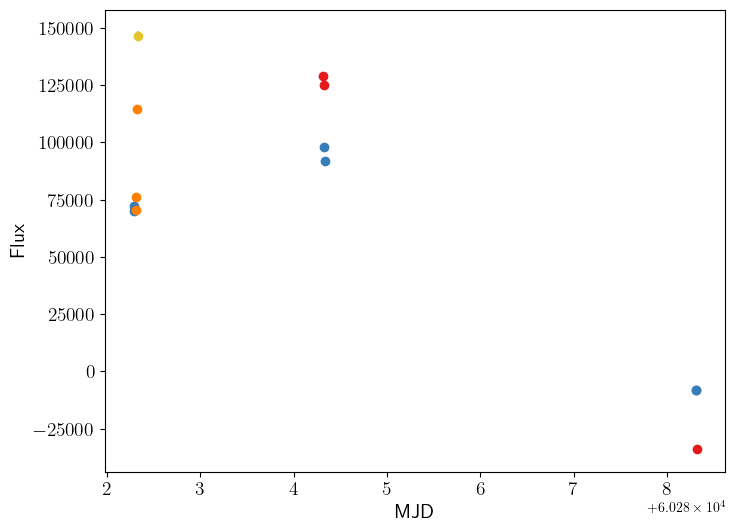

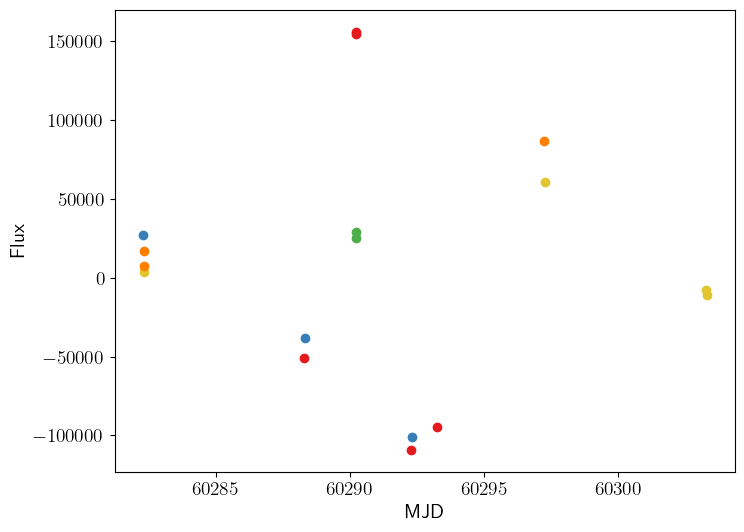

In [362]:
for i in range(0, 2):
    object_id = random.choice(df.select(pl.col("object_id").unique()).to_series().to_numpy())
    print(f"OBJECT ID: {object_id}")
    data = df.filter(pl.col("object_id") == object_id)
    _obj_gps = generate_gp_single_event(data)
#     f, ax = plot_event_data_with_model(data.to_pandas(), obj_model=_obj_gps.to_pandas(), pb_colors=ELASTICC_PB_COLORS)
    filters = list(data.select("filter").unique().to_series())
    f, ax = plot_event(object_id, data.to_pandas(), filters=filters, pb_colors=ELASTICC_PB_COLORS)
    f.savefig(f"{ROOT}/notebooks/light-curves/{label}-{object_id}-light-curve.pdf")

In [363]:
def plot_event_data_with_model(
    obj_data,
    obj_model=None,
    number_col: int = 2,
    show_title: bool = False,
    show_legend: bool = True,
    pb_colors: Dict = {},
) -> None:
    # TODO: Update docstrings
    """Plots real data and model fluxes at the corresponding mjd"""

    f, ax = plt.subplots()
    

    passbands = list(np.unique(obj_model["filter"]))
    for pb in passbands:
        obj_data_pb = obj_data[obj_data["filter"] == pb]  # obj LC in that passband
        if obj_model is not None:
            obj_model_pb = obj_model[obj_model["filter"] == pb]
            model_flux = obj_model_pb["flux"]
            ax.plot(
                obj_model_pb["mjd"],
                model_flux,
                color=pb_colors[pb],
                alpha=0.7,
                label="",
            )
            try:
                model_flux_error = obj_model_pb["flux_error"]
                ax.fill_between(
                    x=obj_model_pb["mjd"],
                    y1=model_flux - model_flux_error,
                    y2=model_flux + model_flux_error,
                    color=pb_colors[pb],
                    alpha=0.15,
                    label=None,
                )
            except Exception as e:
                print(e)
        ax.errorbar(
            obj_data_pb["mjd"],
            obj_data_pb["flux"],
            obj_data_pb["flux_error"],
            fmt="o",
            color=pb_colors[pb],
            label=pb[-1],
        )
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Flux units")
    if show_title:
        ax.title(
            "Object ID: {}\nPhoto-z = {:.3f}".format(obj_data.meta["name"], obj_data.meta["z"])
        )
    if show_legend:
        ax.legend(
            ncol=number_col,
            handletextpad=0.3,
            borderaxespad=0.3,
            labelspacing=0.2,
            borderpad=0.3,
            columnspacing=0.4,
        )

    return f, ax


In [364]:
import time as t

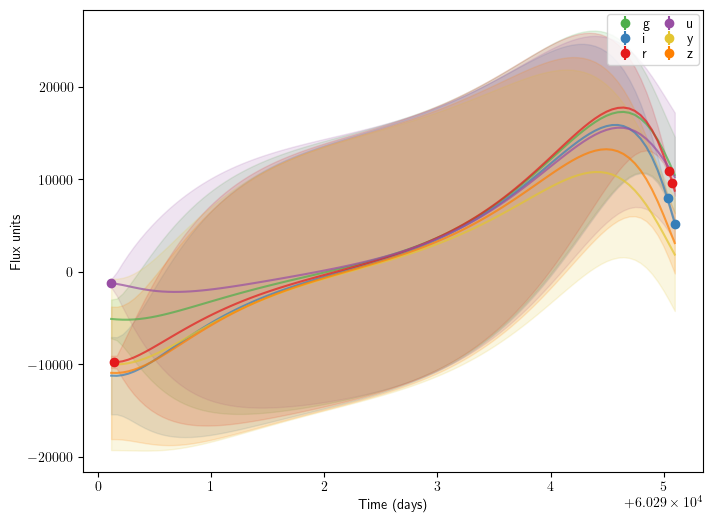

In [379]:
object_id = random.choice(df.select(pl.col("object_id").unique()).to_series().to_numpy())
data = df.filter(pl.col("object_id") == object_id)
_obj_gps = generate_gp_single_event(data)
f, ax = plot_event_data_with_model(data.to_pandas(), obj_model=_obj_gps.to_pandas(), pb_colors=ELASTICC_PB_COLORS)
f.savefig(f"{ROOT}/notebooks/light-curves/{label}-{CLASS_MAPPING.get(label)}-{object_id}-light-curve-t{int(t.time())}.pdf")

In [26]:
filters = list(data.select("filter").unique().to_series())

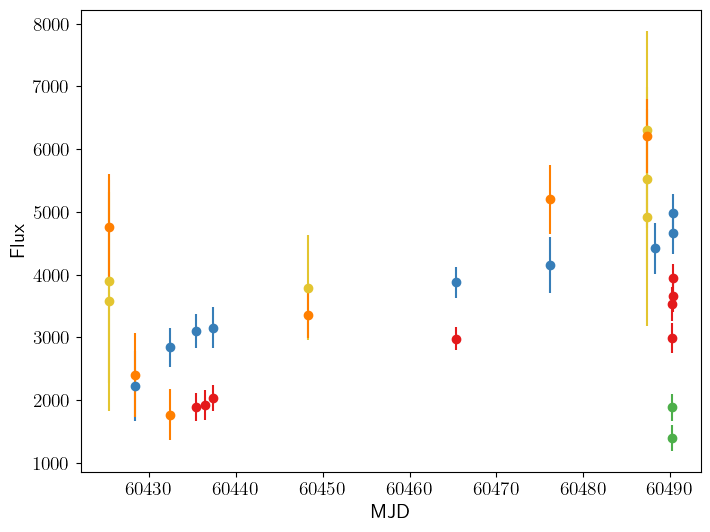

In [27]:
f, ax = plot_event(object_id, data.to_pandas(), filters=filters, pb_colors=ELASTICC_PB_COLORS)